# Ground Based Observation

If you make observations on the ground, the biggest problem is the atmosphere. The atmosphere makes two important problems:

* Seeing
* Extinction (= scattering + absorption)

In the following, we will explore what seeing and extinction are, and finally learn how to get the "real" magnitude from instrumental magnitude.

## Seeing

Seeing is one of the critical problems. You may refer to [Here](http://astro.snu.ac.kr/~jskang/seeing/seeing.html) and grasp the meaning of seeing. In this section, we ignore the instrumental seeing, which usually is a low-frequency component.

Because of the atmospheric seeing, the point source is smoothed from its own "point". The function which describes this spreadness is called the **point spread function**, or just **psf**.

There are two most widely used psfs: [Gaussian](https://en.wikipedia.org/wiki/Gaussian_function) and [Moffat](https://en.wikipedia.org/wiki/Moffat_distribution). The first suggestion of using Moffat profile was made in 1969 by A. F. J. Moffat in [this paper](http://adsabs.harvard.edu/cgi-bin/bib_query?bibcode=1969A%26A.....3..455M&db_key=AST). 

\begin{equation}
	f_{\rm Gauss}(r) =\frac{1}{\sqrt{2 \pi \sigma^2}} e^{ -(r-r_0)^2/2\sigma^2 } 
    \qquad f_{\rm Moffat} (r) = A \left [ 1 + \left ( \frac{r-r_0}{R} \right )^2 \right ]^{-\beta}
\end{equation}

Here, $A$ in the Moffat profile is the normalization constant. $r$ and $r_0$ are the distance from the center and the position of the center. By integration, I obtained $ A = \frac{\Gamma(\beta)}{R\sqrt{\pi} \Gamma(\beta-\frac{1}{2})} $ for normalization. The parameter $R$ is called the core width and $\beta$ is called the power. Moffat considered atmospheric turbulence, instrumental abberation, and photographic receiver, which may not fit perfectly to modern devices. Thus, in modern CCD observations, especially those done until 2000s, $\beta$ is usually fixed as 1.5 or 2.5. 

In uniform atmospheric seeing condition, psf should appear symmetric, i.e., isophotal curves should look like a circle. It actually is rarely the case. We encounter elliptical, or even irregularly shaped isophotes. In such
cases, we have to make elliptical model rotated by certain angle. Those fitting can be done from Astropy, so do not worry too much about how to construct mathermatical formalism. It is enough to know the concept and be able to derive FWHM, HWHM, or so.

In the following example, I will show you the difference between Gaussian and Moffat in 1-D simple case.

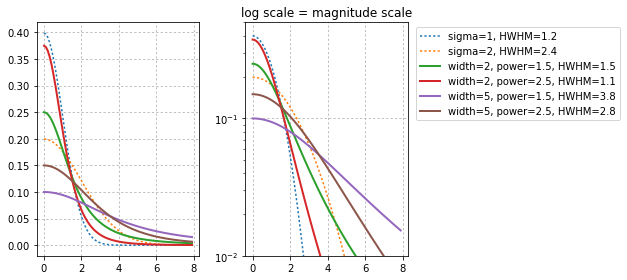

In [32]:
from astropy.modeling.functional_models import Moffat1D, Gaussian1D
from scipy.special import gamma as G
import numpy as np
from matplotlib import pyplot as plt

def norm_gauss(sigma):
    return 1/np.sqrt(2 * np.pi * sigma**2)

def norm_moffat(width, power):
    return G(power) / (width * np.sqrt(np.pi) * G(power - 1/2))

def HWHM_moffat(width, power):
    return width * np.sqrt( 2**(1/power) - 1)

x       = np.arange(0,8,0.1)
sigma   = np.array([1, 2])
width   = np.array([2, 5])
power   = np.array([1.5, 2.5])


ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
for s in sigma:
    gauss  = Gaussian1D(amplitude=1, mean=0, stddev=s)    
    ax1.plot(x, norm_gauss(s)*gauss(x), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))
    ax2.plot(x, norm_gauss(s)*gauss(x), ls=":", 
             label="sigma={0:.0f}, HWHM={1:.1f}".format(s, 2.355*s/2))

for w in width:
    for p in power:
        moffat = Moffat1D(amplitude=1, x_0=0, gamma=w, alpha=p)
        HWHM   = HWHM_moffat(w, p)
        ax1.plot(x, norm_moffat(w, p) * moffat(x), lw=2,
                 label='w={0:.0f}, p={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))
        ax2.plot(x, norm_moffat(w, p) * moffat(x), lw=2,
                 label='width={0:.0f}, power={1:.1f}, HWHM={2:.1f}'.format(w, p, HWHM))
ax2.set_yscale('log')
ax1.grid(ls=":")
ax2.grid(ls=":")
ax2.set_ylim(0.01, 0.5)
ax2.set_title('log scale = magnitude scale')
plt.legend(bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

Moffat describes in his 1969 paper that

> Two-dimensional intensity profiles of focal stellar images in photographic emulsions were derived by convolving gaussian seeing distributions with diffraction proffles and emulsion scattering functions. **The results predict too low an intensity for large radial distances from the centre of the image**, contradicting the assumption that seeing is gaussian.

He noted that the stellar profile is too bright than the good-fitted Gaussian at larger radius, and this contradicts with the old assumption that seeing profile is Gaussian. This can be seen from the above figure I drew. Compare blue dotted (Gauss) and red solid lines (Moffat). The HWHMs are 1.2 and 1.1, so you may expect the latter to have more "concentrated" profile. But at radius larger than about 1.5, latter becomes larger. 

This means the Gaussian fitting may not always be a good choice, especially in the presence of atmosphere.

## Extinction

Because of the atmosphere, stellar flux diminishes because of absorption and scattering. It is mainly because of the change in weather; the same star can appear to have different flux every time, even though the exposure time and instruments are exactly the same. This of course depends on the thickness of atmosphere in the path of stellar light. More complicated issue is that this extinction is also a function of wavelength, so you have to apply different extinction factor for different filters, *in principle*. 


### Flux Extinction
Under parallel uniform atmosphere assumption, the flux diminishes by a factor of $e^{-\tau}$, where $\tau$ is the optical depth. In magnitude system, i.e., the logarithmic scale, this means the increase in magnitude is proportional to the airmass, $X = \sec(z)$: $m(X) = m_0 + k_X X$ where $m$ is the observed magnitude, $m_0$ is the magnitude if it were not for the atmosphere, and $k_X$ is a constant.


### Wavelength Dependence
In broad-band observation, the word "wavelength" can be substituted by "filter". For example, if we use UBV filters, we need to find coefficients $a$ and $k_{XC}$ from $m = m_0 + a({\rm B}-{\rm V}) + k_{XC} X ({\rm B}-{\rm V})$. Fortunately, $a$ is very small ($|a| \lesssim 0.1$), and $k_{\rm XC}$ is nearly zero for most instances. Especially the introduction of $k_{XC}$ increases the uncertainty in many cases, so it is not usually used unless the sky is very clear.

In short, we will ignore the wavelength dependence of extinction.

## Zero-point

What we will calculate from program or software is just $m_{\rm inst} = 2.5 \log_{10} ({\rm photon~count})$ (the **instrumental magnitude**), i.e., the un-normalized "photon count". In such cases, even the Moon may appear to have magnitude like 5 magnitude, which is non-sensical. The normalization to photon count can be done by subtracting certain value from instrumental magnitude, which is mathematically identical to the normalization (think about Pogson's formula). 

The correction to this kind of problem is done by **zeropoint** magnitude. If the zeropoint is denoted as $m_z$, we get the real magnitude as $m = m_{\rm inst} - m_z$.

## Final Result
Combining the zeropoint correction and extinction correction, we get

\begin{equation}
	m_0 = m_{\rm inst} - m_z - k_X X \quad( - {\rm wavelength~correction~terms})~.
\end{equation}

This process, transforming the instrumental magnitude to the "real" magnitude, is called the **standardization**.

## Standardization in Practice

Now, how do we get $m_z$ and $k_X$? What we know is only $X$ and what we can calculate is only $m_{\rm inst}$! Fortunately, we have some stars which have very accurately known $m_0$ values. These are called the **standard stars**. Some famous ones are **Landolt standard stars**.

So the strategy is clear: Take images of standard stars at different airmasses, at nearly identical sky conditions. Plot $m_{\rm inst} - m_0$ VS $X$, and the slope and intercept will be $k_X$ and $m_z$, respectively. This is only true when we neglect the wavelength dependency of extinction. Note that these two depends on sky condition, i.e., **these should be determined at each observation**.

The easiest case occurs if the targets of interst are at almost identical zenith distance (i.e., constant $X$). Observation on bright star clusters are such cases. Then we can regard $k_X X$ as a constant, and set it as part of $m_z$.
